<a href="https://colab.research.google.com/github/RamezNabil/Breast-Cancer-Histopathology-Image-Classification-Transfer-Learning/blob/main/Breast_Cancer_Histopathology_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up Kaggle Datasets

In [1]:
!pip install -q kaggle

In [ ]:
# Upload your Kaggle API json file
from google.colab import files
files.upload()

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-08-13 06:53:06          10617  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6489  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2441  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2644  
promptcloud/car

Downloading the Dataset

In [4]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [00:52<00:00, 45.1MB/s]
100% 3.10G/3.10G [00:52<00:00, 63.0MB/s]


Extracting Dataset

In [ ]:
!unzip "/content/breast-histopathology-images.zip" -d Dataset

In [6]:
%rm -rf Dataset/IDC_regular_ps50_idx5

Pre-Processing

In [12]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# from tensorflow.keras import layers, models, regularizers
# from keras.constraints import maxnorm

In [7]:
directory = '/content/Dataset/'

def load_data():
    features = []
    label = []
    for folder in os.listdir(directory):
        for labelfolder in os.listdir(directory + folder):
            for img in os.listdir(directory + folder + '/' + labelfolder):
              if len(label) == 15000:
                  print('Data Loaded')
                  return features, label
              label.append(int(labelfolder))
              img_data = cv2.imread(os.path.join(directory, folder, labelfolder, img))
              img_data = cv2.resize(img_data, (224, 224))
              features.append(img_data)


def shuffle_data(features, label):
    # shuffle both lists
    both = list(zip(features, label))  # join both arrays together
    random.shuffle(both)  # shuffle
    b: object
    a, b = zip(*both)  # disconnect them from each other
    print('Data Shuffled')
    return a, b

In [8]:
features, label = load_data()
features, label = shuffle_data(features, label)

# Change the arrays into numpy arrays, and reshaping them.
X_train = np.array(features[:12000]).reshape(-1, 224, 224, 3)
y_train = np.array(label[:12000])
X_test = np.array(np.array(features[12000:])).reshape(-1, 224, 224, 3)
y_test = np.array(label[12000:])

Data Loaded
Data Shuffled


Model

Epoch 1/5
375/375 [==============================] - 33s 76ms/step - loss: 0.3938 - accuracy: 0.8319 - val_loss: 0.3173 - val_accuracy: 0.8757
Epoch 2/5
375/375 [==============================] - 27s 73ms/step - loss: 0.3265 - accuracy: 0.8637 - val_loss: 0.2973 - val_accuracy: 0.8790
Epoch 3/5
375/375 [==============================] - 27s 73ms/step - loss: 0.3099 - accuracy: 0.8710 - val_loss: 0.2935 - val_accuracy: 0.8760
Epoch 4/5
375/375 [==============================] - 27s 72ms/step - loss: 0.3002 - accuracy: 0.8766 - val_loss: 0.2836 - val_accuracy: 0.8840
Epoch 5/5
375/375 [==============================] - 27s 72ms/step - loss: 0.2923 - accuracy: 0.8803 - val_loss: 0.2790 - val_accuracy: 0.8833


Text(0, 0.5, 'Validation Accuracy')

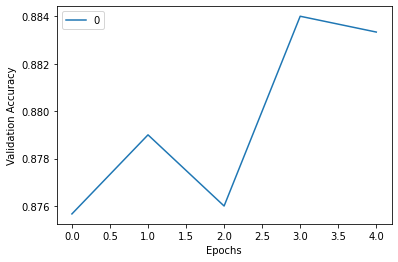

In [30]:
# Build the model
base_model = tf.keras.applications.EfficientNetB0(False)
base_model.trainable = False
inputs = tf.keras.layers.Input((224,224,3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(1, 'sigmoid')(x)
model = tf.keras.Model(inputs, output)

# Compile the model
model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

# Fit the model
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=5)

# Plot validation accuarcy
pd.DataFrame(history.history["val_accuracy"]).plot()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

Fine-Tuning

In [31]:
# Unfreezing some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Compile the model
model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.Adam(lr=0.000025),
              metrics = ["accuracy"])

# Fit the model
history_finetune = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, initial_epoch = history.epoch[-1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 5/10
375/375 [==============================] - 34s 79ms/step - loss: 0.2817 - accuracy: 0.8831 - val_loss: 0.2672 - val_accuracy: 0.8893
Epoch 6/10
375/375 [==============================] - 28s 76ms/step - loss: 0.2663 - accuracy: 0.8923 - val_loss: 0.2677 - val_accuracy: 0.8903
Epoch 7/10
375/375 [==============================] - 29s 76ms/step - loss: 0.2566 - accuracy: 0.8963 - val_loss: 0.2530 - val_accuracy: 0.8980
Epoch 8/10
375/375 [==============================] - 28s 76ms/step - loss: 0.2475 - accuracy: 0.8965 - val_loss: 0.2562 - val_accuracy: 0.8950
Epoch 9/10
375/375 [==============================] - 28s 76ms/step - loss: 0.2392 - accuracy: 0.9040 - val_loss: 0.2476 - val_accuracy: 0.9007
Epoch 10/10
375/375 [==============================] - 34s 90ms/step - loss: 0.2330 - accuracy: 0.9043 - val_loss: 0.2511 - val_accuracy: 0.9000


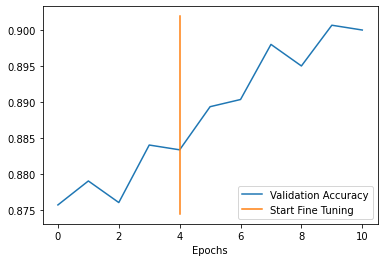

In [32]:
# plotting val accuracy before and after fine-tuning
val_acc = history.history["val_accuracy"]
total_val_acc = val_acc + history_finetune.history["val_accuracy"]

plt.plot(total_val_acc, label='Validation Accuracy')
plt.plot([4, 4], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.show()